Update: online learning and

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
from time import time

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode

py.sign_in('imaginationsuper', 'PQj7gXzsTJFqNKsXkWMT')
init_notebook_mode(connected=True)

In [2]:
def universe_partition(data, d1=10, d2=10):
    x_max, x_min = data.max(axis=0), data.min(axis=0)
    std_val = data.std(axis=0)
    len_val = np.round(std_val / 10)
#     len_val = 30
    u_max, u_min = int(x_max+d2), int(x_min-d1) # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_s = u_b[:-1] # u1
    u_e = u_b[1:] # u2
    u_discourse = zip(u_s, u_e) # interval
    return u_discourse

def set_fuzzy_numbers(u_discourse):
    fuzzy_numbers = list()
    for i, u_i in enumerate(u_discourse):
        if (i!=0) and (i!=len(u_discourse)-1):
            u_l, u_r = u_discourse[i-1], u_discourse[i+1]
            A_l, A_r = np.mean(u_l), np.mean(u_r)
            fuzzy_numbers.append((A_l, u_i[0], u_i[1], A_r))
    return fuzzy_numbers

In [3]:
def membership_evaluation(value, fuzzy_number):
    A_l, u_1, u_2, A_r = fuzzy_number
    mu = 0 # membership indication
    try:
        if np.logical_and(value>=A_l, value <u_1):
            mu = (value - A_l) / (u_1 - A_l)
        elif np.logical_and(value>=u_1, value<=u_2):
            mu = 1
        elif np.logical_and(value>u_2, value<=A_r):
            mu = (value - u_2) / (A_r - u_2)
    except ZeroDivisionError:
        mu = 0
    return mu

def membership_assignment(value_time_series, fuzzy_numbers):
    n_fuzzy_numbers = len(fuzzy_numbers)
    membership_list = list()
    for i, value in enumerate(value_time_series):
        value_rep = [value] * n_fuzzy_numbers
        memberships = map(lambda val, A: membership_evaluation(val, A), value_rep, fuzzy_numbers)
        max_index, _ = max(enumerate(memberships), key=operator.itemgetter(1))
        membership_list.append(max_index)
    return membership_list

def get_membership(value, fuzzy_numbers):
    n_fuzzy_numbers = len(fuzzy_numbers)
    membership_index = 0
    value_rep = [value] * n_fuzzy_numbers
    memberships = map(lambda val, Ai: membership_evaluation(val, Ai), value_rep, fuzzy_numbers)
    membership_index, _ = max(enumerate(memberships), key=operator.itemgetter(1))
    return membership_index

In [4]:
def FLR(membership_time_series): # transition between consecutive observations
    transitions = list()
    for j, Aj in enumerate(membership_time_series):
        if j!=0:
            Ai = membership_time_series[j-1]
            transitions.append((Ai, Aj))
    return transitions

def FLR_weight(transitions, time_series): # compute jump frequency by FLR
    jumps = map(lambda x: x[1]-x[0], transitions) # compute jumps by transitions 
    jump_time_series = zip(jumps, time_series) # assign timestamp for each jump beta^t_p,p+k
    jump_counts = defaultdict(list) 
    for key, value in jump_time_series:
        jump_counts[key].append(value) # count jump by its timestamps
    jump_counts = {key: sum(value) for key, value in jump_counts.items()} # sum up total time for each jump
    total_count = float(sum(jump_counts.values()))
    for key, value in jump_counts.iteritems(): 
        jump_counts[key] = value / total_count # normalize jumps as weights
    return jump_counts

def FRG_weight(transitions, time_series): 
    transition_time_series = zip(transitions, time_series)
    transition_groups = map(lambda x: (x[0][0], (x[0][1], x[1])), transition_time_series) 
    transition_weights = defaultdict(list)
    for key, value in transition_groups:
        transition_weights[key].append(value) # group transitions by initial state A_i
    transition_weights = {key: dict(value) for key, value in transition_weights.items()}
    for key, value in transition_weights.iteritems():
        total_weight = float(sum(value.values()))
        value = {k: (v/total_weight) for k, v in value.items()} # normalize weight inside each group
        transition_weights[key] = value
    return transition_weights

In [5]:
# forecasting by fuzzy numbers
def fuzzy_add(A, B): # Proposition #1 (1)
    return tuple([sum(x) for x in zip(A, B)])

def fuzzy_scale(c, A): # Proposition #1 (2)
    cA = [c*a for a in A]
    if c>=0:
        return tuple(cA)
    else:
        cA.reverse()
        return tuple(cA)

def forecast_jump(i, s, A_list):
    jumps = s.keys() # possible jumps
    m = len(A_list) # number of fuzzy numbers in model
    sA_list = list()
    sk_list = list()
    Aip_list = list()
    sA = tuple([0]*len(A_list[0]))
    for k in jumps:
        ip = k+i
        if (ip>=0 and ip<m): # check if index is within range
            sk_list.append(s[k])
            Aip_list.append(A_list[ip])
    sk_tot = sum(sk_list)
    sk_list = [sk/float(sk_tot) for sk in sk_list] # normalize locally
    for i in range(len(sk_list)):
        sA_list.append(fuzzy_scale(sk_list[i], Aip_list[i]))
    if len(sA_list)>0:
        for sa in sA_list:
            sA = fuzzy_add(sA, sa)
    return sA
    
def forecast_transition(i, w, A_list):
    wA = tuple([0]*len(A_list[0])) # default FLG relation
    if i in w.keys():
        for kj, v in w[i].iteritems():
            wA = fuzzy_add(wA, fuzzy_scale(v, A_list[kj]))
    return wA

def forecast_price(As, Aw, gamma=0.1):
    if gamma<0 or gamma>1:
        raise ValueError("gamma should be between 0.0 and 1.0 (inclusive on both ends)")     
    wAi = fuzzy_scale(1-gamma, Aw)
    if (sum(wAi) == 0): # no FLR observed in history
        sAi = As
    else:
        sAi = fuzzy_scale(gamma, As)
    Ai_pred = fuzzy_add(sAi, wAi)
    return np.mean(Ai_pred)

In [6]:
start_time = time()
# datafile = '../data/IBEX35(201301-201512).xlsx'
# xl = pd.ExcelFile(datafile)
# df = xl.parse(u'Sheet1')
datafile = '../data/IBEX35.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%y')
df = pd.read_csv(datafile, header=0, parse_dates=['Date'], date_parser=dateparse)

In [7]:
split_date = pd.datetime.strptime('2014-12-31', '%Y-%m-%d')
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]
first_date = train_data['Date'][0] - pd.DateOffset(days=1)

In [8]:
option = 'Price'
pred_prices = list()
actual_prices = test_data[option].tolist()[1:]
indices = test_data.index
for i in range(len(indices)-1):
    stm = time()
    #id = indices[i]
    prev = test_data.iloc[i]
    train_data.append(prev)
    print("Update data: %s seconds" % str(time() - stm))
    stm = time()
    u_discourse = universe_partition(train_data[option], d1=1053, d2=912)
    print("Partition discourse: %s seconds" % str(time() - stm))
    stm = time()
    A_list = set_fuzzy_numbers(u_discourse)
    print("Create fuzzy number: %s seconds" % str(time() - stm))
    stm = time()
    train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=A_list)
#     train_data_ms = [ms+1 for ms in train_data_membership_series]
    print("Update fuzzy membership: %s seconds" % str(time() - stm))
    stm = time()
    transition_FLR = FLR(train_data_membership_series)
    print("Update FLR: %s seconds" % str(time() - stm))
    stm = time()
    train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
    jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    print("Update jump weights: %s seconds" % str(time() - stm))
    stm = time()
    transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    print("Update transition weights: %s seconds" % str(time() - stm))
    stm = time()
    # forecasting current test data
    price = prev[option]
    index = get_membership(price, A_list)
    print("Assign membership for test case: %s seconds" % str(time() - stm))
    stm = time()
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    print("Forecast next price: %s seconds" % str(time() - stm))
    stm = time()
    pred_prices.append(next_price)
    
print "RMSE = "+str(np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print "Time cost: "+str(time()-start_time)+" seconds"    

Update data: 0.00361084938049 seconds
Partition discourse: 0.000436067581177 seconds
Create fuzzy number: 0.0012059211731 seconds
Update fuzzy membership: 0.105316877365 seconds
Update FLR: 0.000313997268677 seconds
Update jump weights: 0.0434730052948 seconds
Update transition weights: 0.00114107131958 seconds
Assign membership for test case: 0.000694990158081 seconds
Forecast next price: 0.000246047973633 seconds
Update data: 0.00457501411438 seconds
Partition discourse: 0.00306296348572 seconds
Create fuzzy number: 0.00434112548828 seconds
Update fuzzy membership: 0.14959192276 seconds
Update FLR: 0.000258922576904 seconds
Update jump weights: 0.0251760482788 seconds
Update transition weights: 0.000633955001831 seconds
Assign membership for test case: 0.000414133071899 seconds
Forecast next price: 0.000248908996582 seconds
Update data: 0.00721406936646 seconds
Partition discourse: 0.00125002861023 seconds
Create fuzzy number: 0.010528087616 seconds
Update fuzzy membership: 0.1174781

In [11]:
print(train_data_membership_series)

[16, 16, 16, 16, 16, 17, 18, 18, 19, 18, 18, 18, 19, 18, 19, 18, 18, 18, 20, 19, 19, 18, 15, 14, 11, 13, 13, 13, 14, 13, 15, 15, 15, 13, 13, 15, 13, 13, 15, 12, 12, 14, 14, 14, 15, 16, 16, 17, 18, 17, 17, 17, 19, 16, 17, 16, 16, 15, 16, 14, 13, 11, 11, 12, 12, 11, 10, 11, 11, 13, 13, 13, 12, 12, 11, 11, 12, 13, 15, 16, 15, 15, 17, 16, 17, 18, 18, 18, 18, 18, 18, 17, 17, 18, 17, 18, 17, 17, 15, 16, 15, 16, 17, 16, 17, 15, 16, 15, 15, 14, 15, 14, 13, 13, 13, 14, 14, 14, 11, 11, 9, 9, 9, 11, 11, 10, 12, 10, 10, 12, 11, 13, 12, 13, 13, 11, 11, 10, 10, 12, 12, 12, 13, 14, 15, 16, 16, 17, 17, 18, 18, 18, 17, 18, 19, 19, 19, 20, 20, 19, 20, 18, 17, 17, 19, 19, 18, 16, 16, 16, 16, 17, 17, 17, 17, 18, 19, 20, 21, 21, 22, 22, 22, 24, 23, 24, 23, 23, 24, 25, 23, 24, 25, 26, 25, 26, 26, 25, 27, 29, 28, 29, 29, 30, 31, 32, 32, 31, 30, 30, 30, 29, 30, 29, 31, 30, 31, 30, 30, 29, 29, 30, 29, 29, 29, 29, 29, 28, 27, 28, 28, 29, 29, 30, 30, 30, 29, 28, 27, 26, 26, 27, 26, 25, 25, 25, 26, 26, 27, 29, 29

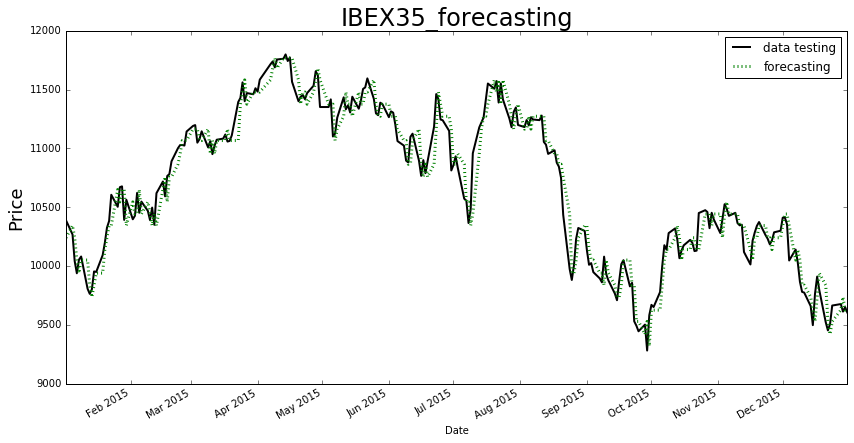

In [9]:
df_test = pd.DataFrame(test_data.iloc[1:]['Date'])
df_test['data testing'] = pd.Series(actual_prices).values
df_test['forecasting'] = pd.Series(pred_prices).values
df_test.index = df_test['Date']
plt.figure(figsize=(14,7))
df_test['data testing'].plot(style='k-', linewidth=2, label='data testing')
df_test['forecasting'].plot(style='g:', linewidth=3, label='forecasting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_forecasting", fontsize=24)